# Titanic Survival Prediction - Kaggle Competition
## Author: Monit Sharma
### Date: 01/12/24



In [24]:
# Import libraries
import pandas as pd               # Data manipulation
import numpy as np                # Numerical operations
import matplotlib.pyplot as plt   # Plotting
import seaborn as sns             # Advanced plotting

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


In [25]:
# Load datasets
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
gender_submission = pd.read_csv('dataset/gender_submission.csv')

# Display first few rows of training data
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


First thing to do is to check for null values

In [26]:
# check the missing values 
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


A lot of age data is missing, since it's numeric, we will fill the missing values with the median age. The median is robust to outliers and represents a good central value

In [27]:
train['Age'] = train['Age'].fillna(train['Age'].median())
test['Age'] = test['Age'].fillna(test['Age'].median())


The `cabin` column also has too many missing values. Instead of filling them, it's best to drop this column, since I think it's unlikely to provide usefull information

In [28]:
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)


Handling missing `Embarked`, it has only 2 missing values, so we fill it with the most frequent value (mod)

In [29]:
# Filling 'Embarked'
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
test['Embarked'] = test['Embarked'].fillna(test['Embarked'].mode()[0])




Let's recheck for the missing values

In [30]:
print(train.isnull().sum())
print(test.isnull().sum())


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
dtype: int64


There's still one missing `Fare` value, so we will handle it like the `Age` and fill it with median fare

In [31]:
# Fill missing Fare value with the median Fare
test['Fare'] = test['Fare'].fillna(test['Fare'].median())


In [32]:
print(train.isnull().sum())
print(test.isnull().sum())


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


The next step is to feature engineer to prepare the data for training the model.

### 1. Encoding Categorical Variables

`Sex` and  `Embarked` can be converted into numeric values, since ML works better with number, so male can be 0 and female can be 1, similary for embarkment, we can have , 0, 1 and 2

In [33]:
# Encode categorical variables
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})

train['Embarked'] = train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
test['Embarked'] = test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})


### 2. Create New Features

<li> Combine `SibSp` (siblings/spouse) and `Parch` (parents/children) into one column `FamilySize` to represent the size of passenger's family

<li> Extract te titles from the `Name` column and encode them as a new feature as well

In [34]:
# Create FamilySize
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']

# Extract titles from names
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify titles
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
train['Title'] = train['Title'].replace(rare_titles, 'Rare')
test['Title'] = test['Title'].replace(rare_titles, 'Rare')

# Map titles to numeric values
title_map = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
train['Title'] = train['Title'].map(title_map)
test['Title'] = test['Title'].map(title_map)


### 3. Drop Unnecessary Columns

Some columns are not useful for predictions like `Name`, `Ticket`, `PassngerID`. We can drop them

In [35]:
# Save PassengerId for the test dataset
test_ids = test['PassengerId']




In [36]:
train.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)
test.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)


Recheck the data now

In [37]:
print(train.head())
print(test.head())


   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  FamilySize  \
0         0       3    0  22.0      1      0   7.2500         2           1   
1         1       1    1  38.0      1      0  71.2833         0           1   
2         1       3    1  26.0      0      0   7.9250         2           0   
3         1       1    1  35.0      1      0  53.1000         2           1   
4         0       3    0  35.0      0      0   8.0500         2           0   

   Title  
0    0.0  
1    2.0  
2    1.0  
3    2.0  
4    0.0  
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  FamilySize  Title
0       3    0  34.5      0      0   7.8292         1           0    0.0
1       3    1  47.0      1      0   7.0000         2           1    2.0
2       2    0  62.0      0      0   9.6875         1           0    0.0
3       3    0  27.0      0      0   8.6625         2           0    0.0
4       3    1  22.0      1      1  12.2875         2           2    2.0


In [38]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title
0,0,3,0,22.0,1,0,7.2500,2,1,0.0
1,1,1,1,38.0,1,0,71.2833,0,1,2.0
2,1,3,1,26.0,0,0,7.9250,2,0,1.0
3,1,1,1,35.0,1,0,53.1000,2,1,2.0
4,0,3,0,35.0,0,0,8.0500,2,0,0.0


In [39]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title
0,3,0,34.5,0,0,7.8292,1,0,0.0
1,3,1,47.0,1,0,7.0000,2,1,2.0
2,2,0,62.0,0,0,9.6875,1,0,0.0
3,3,0,27.0,0,0,8.6625,2,0,0.0
4,3,1,22.0,1,1,12.2875,2,2,2.0


Now, our data is cleaned and feature engineered, we can proceed with building our Random Forest Model

### 1. Define Features and Target Variables

The target variable `y` is the column w e want to predict `Survived`
and the feature `x` are the columns we use to make predictions ( rest of the columns)

In [40]:
# Separate features and target variable in the training dataset
X = train.drop('Survived', axis=1)
y = train['Survived']

# Use the test dataset as features for final predictions (PassengerId is already dropped)
test_X = test


We split the data into `x` and `y` to separate predictors from the target, which helps train and evaluate the model

### 2. Split Data into Training and Validation Set

As the name suggests, the validation subsets helps evaluate the model before testing it on  unseen data

In [41]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


`test_size=0.2` reserved $20\%$ of data for validation

### 3. Train the Random Forest Model

In [42]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest with default parameters
rfc = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=8, max_features='sqrt')

# Train the model on the training set
rfc.fit(X_train, y_train)


RandomForestClassifier(max_depth=8, random_state=42)

<li> random_state=42: Ensures consistent results across runs.
<li> n_estimators=100: Number of trees in the forest (default is 100).
<li> max_depth=8: Limits the depth of each tree to prevent overfitting.
<li> max_features='sqrt': Considers a square root of total features at each split to add randomness.

### 4. Evaluate the Model

Predict the target variable for the validation set and calculate metrics like accuracy, precision and recall

Accuracy: 0.8491620111731844
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87       105
           1       0.84      0.78      0.81        74

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



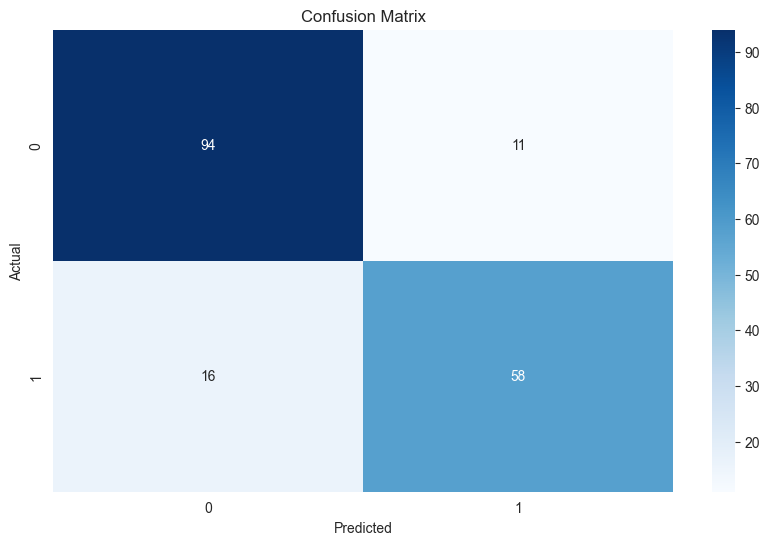

In [43]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the validation set
y_pred = rfc.predict(X_val)

# Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


<Li> Accuracy: Percentage of correct predictions.
<Li> Classification Report: Includes precision, recall, and F1-score for each class.
<Li> Confusion Matrix: Visualizes the number of true positives, true negatives, false positives, and false negatives.

### 5. Tune Hyperparamters using GridSearch CV

To find the best parameters for the model, perform a grid search over a set of possible values

In [44]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy', 
                           verbose=10)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Use the best model from GridSearchCV
best_rfc = grid_search.best_estimator_


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100
[CV 1/5; 1/36] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.853 total time=   0.1s
[CV 2/5; 1/36] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100
[CV 2/5; 1/36] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.846 total time=   0.1s
[CV 3/5; 1/36] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100
[CV 3/5; 1/36] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.796 total time=   0.1s
[CV 4/5; 1/36] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100


[CV 4/5; 1/36] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.803 total time=   0.1s
[CV 5/5; 1/36] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100
[CV 5/5; 1/36] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.831 total time=   0.1s
[CV 1/5; 2/36] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200
[CV 1/5; 2/36] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.846 total time=   0.1s
[CV 2/5; 2/36] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200
[CV 2/5; 2/36] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.846 total time=   0.3s
[CV 3/5; 2/36] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200
[CV 3/5; 2/36] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.796 total time=   0.1s
[CV 4/5; 2/36] START criterion=gini, max_depth=4, max_features=sqrt, n_

<li> param_grid: Defines the range of hyperparameters to test.
<li> cv=5: 5-fold cross-validation ensures robust evaluation of hyperparameters.
<li> scoring='accuracy': Optimizes for accuracy

### 6. Predict on the Test Data

In [45]:
# Use the preserved PassengerId
output = pd.DataFrame({'PassengerId': test_ids, 'Survived': test_predictions})

# Save the output as a CSV file
output.to_csv('titanic_submission.csv', index=False)
print("Submission saved as titanic_submission.csv")


Submission saved as titanic_submission.csv


$$ 0.77751 $$

We need to improve this, we need to improve the model performance

### 1. Additional Feature Engineering

##### Refine Existing Features
 
 We can bin ages into categories, instead of using raw `Age`, categorize it into age groups

In [46]:
bins = [0, 12, 18, 35, 60, 80]
labels = [0, 1, 2, 3, 4]
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels)
test['AgeGroup'] = pd.cut(test['Age'], bins=bins, labels=labels)


Create categories for the `Fare` column

In [47]:
train['FareGroup'] = pd.qcut(train['Fare'], 4, labels=[0, 1, 2, 3])
test['FareGroup'] = pd.qcut(test['Fare'], 4, labels=[0, 1, 2, 3])


#### Interacting Features

Combine features to create interaction variables

Categorize family size into small, medium or large

In [48]:
train['FamilySizeGroup'] = train['FamilySize'].apply(lambda x: 0 if x == 0 else (1 if x <= 3 else 2))
test['FamilySizeGroup'] = test['FamilySize'].apply(lambda x: 0 if x == 0 else (1 if x <= 3 else 2))


Create a new feature `IsAlone` if the passenger is infact alone

In [49]:
train['IsAlone'] = (train['FamilySize'] == 0).astype(int)
test['IsAlone'] = (test['FamilySize'] == 0).astype(int)


#### Feature Scaling

Some models, including Random Forest, don't require scaling, but if you consider something like Log Regression or Gradient Boosting, sclaing numerical features can help

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[['Age', 'Fare']] = scaler.fit_transform(train[['Age', 'Fare']])
test[['Age', 'Fare']] = scaler.transform(test[['Age', 'Fare']])


### 2. Try Different Models

Random Forest is powerful, but we can experiment with other models as well

#### Gradient Boosting Models

XGBoost is an excellent choise for tabular data

In [51]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

print("XGBoost Accuracy:", accuracy_score(y_val, y_pred_xgb))


XGBoost Accuracy: 0.8324022346368715


#### Ensemble Methods

Combine predictions from multiple models to create a more robust prediction

In [52]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42, n_estimators=200)),
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
], voting='soft')

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_val)

print("Voting Classifier Accuracy:", accuracy_score(y_val, y_pred_voting))


Voting Classifier Accuracy: 0.8212290502793296


### 3. Hyperparamter Tuning

Fine tune Random Forest or the other model for optimal performance

In [53]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [4, 6, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=10)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_rfc = grid_search.best_estimator_


Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5; 1/162] START max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 1/162] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.853 total time=   0.1s
[CV 2/5; 1/162] START max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/5; 1/162] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.846 total time=   0.1s
[CV 3/5; 1/162] START max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 1/162] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.796 total time=   0.1s
[CV 4/5; 1/162] START max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 4/5; 1/162] END max_depth=4, max_features=sqrt, min_samp

/Users/monitsharma/codes/Kaggle_competitions/.venv/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


### 4. Handle Class Imbalance

In [54]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=42)
rfc.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

### 5. Cross Validation

Instead of relying on a single train-test split, use k-fold cross validation to better estimate model performance

In [55]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(RandomForestClassifier(random_state=42), X, y, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy:", scores.mean())


10-Fold Cross-Validation Accuracy: 0.8115230961298376


### 6. Feature Selection

Remove unimportant or redundant features to simplify the model

In [57]:
# Check feature importance
importances = rfc.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print(feature_importance)

# Drop less important features based on threshold
X_train_reduced = X_train[['Pclass', 'Sex', 'Fare', 'Title']]
X_val_reduced = X_val[['Pclass', 'Sex', 'Fare', 'Title']]


      Feature  Importance
5        Fare    0.249539
2         Age    0.226097
1         Sex    0.164035
8       Title    0.152377
0      Pclass    0.077515
7  FamilySize    0.051820
6    Embarked    0.031152
3       SibSp    0.029039
4       Parch    0.018425
